## <center>Predict the Sentiment</center>

Competition: Sentiment Analysis Hackathon

## Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.


### Dataset Description:

This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

### Evaluation Metric

We will be using ‘weighted’ F1-measure as the evaluation metric for this competition.

### Pipeline
1) Tokenizer
2) Stopword removal - user handles
3) Stemming
4) POS tagging
5) Dictionary 
6) Rules like Positive sentence with negative verb = negative, negative sentence with negative verb is positive, etc
7) Imbalanced data handling
8) Model - Linear regression, Random Forest
9) Textblob for sentiment analysis
10) Use vader sentiment lib
11) wordcloud

In [1]:
# Importing Libraries 
import pandas as pd
import numpy as np
import warnings
import re
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
from html.parser import HTMLParser
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pankaj.pa.kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

In [2]:
# Loading Data
df_train = pd.read_csv("data/train.csv")
print(df_train.shape)
df_train.head()

(7274, 3)


,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [3]:
df_test=pd.read_csv('data/test.csv')
print(df_test.shape)
df_test.head()

(1819, 2)


,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 142.1+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
tweet_id    1819 non-null int64
tweet       1819 non-null object
dtypes: int64(1), object(1)
memory usage: 21.4+ KB


## Explore the distribution of labels in the data

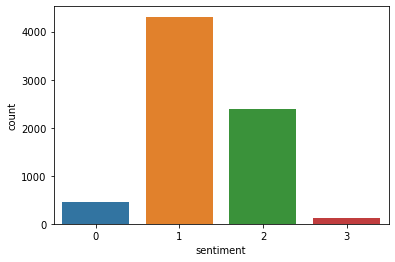

In [6]:
sns.countplot(x='sentiment', data=df_train)
plt.show()

In [6]:
# Merging both the data sets as tweets in both the data set is unstructured
df_combine = df_train.append(df_test, ignore_index = True, sort = False)
df_combine.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0
1,1851,Learning ab Google doodles! All doodles should...,1.0
2,2689,one of the most in-your-face ex. of stealing t...,2.0
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0
4,3604,Line outside the Apple store in Austin waiting...,1.0


In [7]:
print(df_combine.iloc[7274])

tweet_id                                                  7506
tweet        Audience Q: What prototyping tools do you use?...
sentiment                                                  NaN
Name: 7274, dtype: object


In [8]:
# Combine (Merged) Data Set Information
print("Combine Data Set Info - Total Rows | Total Columns | Total Null Values")
print(df_combine.info())

Combine Data Set Info - Total Rows | Total Columns | Total Null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_id     9093 non-null int64
tweet        9092 non-null object
sentiment    7274 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 177.7+ KB
None


We can see above, ID & Tweet column has 49159 has values where as Label column has 31962 values.

## Data processing & cleaning
* Step A : Converting html entities
* Step B : Removing "@user" from all the tweets
* Step C : Changing all the tweets into lowercase 
* Step D : Apostrophe Lookup
* Step E : Short Word Lookup
* Step F : Emoticon Lookup
* Step H : Replacing Special Characters with space
* Step I : Replacing Numbers (integers) with space
* Step J : Removing words whom length is 1

### 1) Converting html entities

In [9]:
print("""Step A : Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)""")

Step A : Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)


In [10]:
html_parser = HTMLParser()

In [11]:
print(type(df_combine['tweet'][0]))
df_combine['tweet'] = df_combine['tweet'].astype(str)
df_combine['clean_tweet'] = df_combine['tweet'].apply(lambda x: html_parser.unescape(x))
df_combine.head(15)

<class 'str'>


,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,Learning ab Google doodles! All doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,This iPhone #SXSW app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,Line outside the Apple store in Austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,#technews One lone dude awaits iPad 2 at Apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,NU user RT @mention New #UberSocial for #iPhon...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,Free #SXSW sampler on iTunes {link} #FreeMusic
9,883,I think I might go all weekend without seeing ...,2.0,I think I might go all weekend without seeing ...


### 2) Removing "@mention" from the tweets

In [12]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [13]:
# remove user handles (@mention)
df_combine['clean_tweet'] = np.vectorize(remove_pattern)(df_combine['clean_tweet'], "@[\w]*")
df_combine.head(15)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,Learning ab Google doodles! All doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,This iPhone #SXSW app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,Line outside the Apple store in Austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,#technews One lone dude awaits iPad 2 at Apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,NU user RT New #UberSocial for #iPhone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,Free #SXSW sampler on iTunes {link} #FreeMusic
9,883,I think I might go all weekend without seeing ...,2.0,I think I might go all weekend without seeing ...


### 3) Converting all the tweets to lowercase 

In [14]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: x.lower())
df_combine.head()

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...


### 4) Apostrophe conversion

In [15]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
apostrophe_dict

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [16]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [17]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,#technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,"sxsw tips, prince, npr videos, toy shopping wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new #ubersocial for #iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free #sxsw sampler on itunes {link} #freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 5) Short Word conversion

In [18]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [19]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,#technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,"sxsw tips, prince, npr videos, toy shopping wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new #ubersocial for #iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free #sxsw sampler on itunes {link} #freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 6) Emoticon conversion

In [20]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
emoticon_dict

{':)': 'happy',
 ':‑)': 'happy',
 ':-]': 'happy',
 ':-3': 'happy',
 ':->': 'happy',
 '8-)': 'happy',
 ':-}': 'happy',
 ':o)': 'happy',
 ':c)': 'happy',
 ':^)': 'happy',
 '=]': 'happy',
 '=)': 'happy',
 '<3': 'happy',
 ':-(': 'sad',
 ':(': 'sad',
 ':c': 'sad',
 ':<': 'sad',
 ':[': 'sad',
 '>:[': 'sad',
 ':{': 'sad',
 '>:(': 'sad',
 ':-c': 'sad',
 ':-< ': 'sad',
 ':-[': 'sad',
 ':-||': 'sad'}

In [21]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,#technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,"sxsw tips, prince, npr videos, toy shopping wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new #ubersocial for #iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free #sxsw sampler on itunes {link} #freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 7) Replacing Punctuations with space

In [22]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 8) Replacing Special Characters with space

In [23]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 9) Replacing Numbers with space

In [24]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,technews one lone dude awaits ipad at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2.0,i think i might go all weekend without seeing ...


### 10) Removing words of length 1

In [25]:
df_combine['clean_tweet'] = df_combine['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df_combine.head()

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of touch ...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should ...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing th...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would pretty awesome if i...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...


### 11) Spelling Correction - With TextBlob Library

In [38]:
text = df_combine['clean_tweet'][0:10].apply(lambda x: str(TextBlob(x).correct()))
text

0    sxswnui saw apple defining language of touch w...
1    learning ab goose doubles all doubles should b...
2    one of the most in your face ex of stealing th...
3    this phone saw pp would pretty awesome if it d...
4    line outside the apple store in austin waiting...
5    technews one lone due awaits pad at apple saw ...
6    saw tips prince nor video toy shopping with zu...
7    no user it new ubersocial for phone now in the...
8             free saw simpler on tunes link freemusic
9    think might go all weekend without seeing the ...
Name: clean_tweet, dtype: object

In [26]:
# Creating token for the clean tweets
df_combine['tweet_token'] = df_combine['clean_tweet'].apply(lambda x: word_tokenize(x))

## Fully formated tweets & there tokens
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet,tweet_token
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of touch ...,"[sxswnui, sxsw, apple, defining, language, of,..."
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should ...,"[learning, ab, google, doodles, all, doodles, ..."
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing th...,"[one, of, the, most, in, your, face, ex, of, s..."
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would pretty awesome if i...,"[this, iphone, sxsw, app, would, pretty, aweso..."
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...,"[line, outside, the, apple, store, in, austin,..."
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,technews one lone dude awaits ipad at apple sx...,"[technews, one, lone, dude, awaits, ipad, at, ..."
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,sxsw tips prince npr videos toy shopping with ...,"[sxsw, tips, prince, npr, videos, toy, shoppin..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new ubersocial for iphone now in th...,"[nu, user, rt, new, ubersocial, for, iphone, n..."
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free sxsw sampler on itunes link freemusic,"[free, sxsw, sampler, on, itunes, link, freemu..."
9,883,I think I might go all weekend without seeing ...,2.0,think might go all weekend without seeing the ...,"[think, might, go, all, weekend, without, seei..."


In [27]:
# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))

In [28]:
# Created new columns of tokens - where stop words are being removed
df_combine['tweet_token_filtered'] = df_combine['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

## Tokens columns with stop words and without stop words
df_combine[['tweet_token', 'tweet_token_filtered']].head(10)

,tweet_token,tweet_token_filtered
0,"[sxswnui, sxsw, apple, defining, language, of,...","[sxswnui, sxsw, apple, defining, language, tou..."
1,"[learning, ab, google, doodles, all, doodles, ...","[learning, ab, google, doodles, doodles, light..."
2,"[one, of, the, most, in, your, face, ex, of, s...","[one, face, ex, stealing, show, yrs, rt, sxsw,..."
3,"[this, iphone, sxsw, app, would, pretty, aweso...","[iphone, sxsw, app, would, pretty, awesome, cr..."
4,"[line, outside, the, apple, store, in, austin,...","[line, outside, apple, store, austin, waiting,..."
5,"[technews, one, lone, dude, awaits, ipad, at, ...","[technews, one, lone, dude, awaits, ipad, appl..."
6,"[sxsw, tips, prince, npr, videos, toy, shoppin...","[sxsw, tips, prince, npr, videos, toy, shoppin..."
7,"[nu, user, rt, new, ubersocial, for, iphone, n...","[nu, user, rt, new, ubersocial, iphone, app, s..."
8,"[free, sxsw, sampler, on, itunes, link, freemu...","[free, sxsw, sampler, itunes, link, freemusic]"
9,"[think, might, go, all, weekend, without, seei...","[think, might, go, weekend, without, seeing, i..."


## Lets create 2 new columns
* One For Stemming
* Second For Lemmatization

### Stemming

In [29]:
stemming = PorterStemmer()

In [30]:
# Created one more columns tweet_stemmed it shows tweets' stemmed version
df_combine['tweet_stemmed'] = df_combine['tweet_token_filtered'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))
df_combine['tweet_stemmed'].head(10)

0    sxswnui sxsw appl defin languag touch differ d...
1    learn ab googl doodl doodl light funni innov e...
2    one face ex steal show yr rt sxsw appl school ...
3    iphon sxsw app would pretti awesom crash everi...
4    line outsid appl store austin wait new ipad sx...
5    technew one lone dude await ipad appl sxsw sto...
6    sxsw tip princ npr video toy shop zuckerberg l...
7    nu user rt new ubersoci iphon app store includ...
8                  free sxsw sampler itun link freemus
9    think might go weekend without see ipad case t...
Name: tweet_stemmed, dtype: object

### Lemmatization

In [31]:
lemmatizing = WordNetLemmatizer()

In [32]:
# Created one more columns tweet_lemmatized it shows tweets' lemmatized version
df_combine['tweet_lemmatized'] = df_combine['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))
df_combine['tweet_lemmatized'].head(10)

0    sxswnui sxsw apple defining language touch dif...
1    learning ab google doodle doodle light funny i...
2    one face ex stealing show yr rt sxsw apple sch...
3    iphone sxsw app would pretty awesome crash eve...
4    line outside apple store austin waiting new ip...
5    technews one lone dude awaits ipad apple sxsw ...
6    sxsw tip prince npr video toy shopping zuckerb...
7    nu user rt new ubersocial iphone app store inc...
8              free sxsw sampler itunes link freemusic
9    think might go weekend without seeing ipad cas...
Name: tweet_lemmatized, dtype: object

In [33]:
## for further analysis we consider 2 columns i.e. "tweet_stemmed" & "tweet_lematized"
df_combine.head(10)

,tweet_id,tweet,sentiment,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1701,#sxswnui #sxsw #apple defining language of tou...,1.0,sxswnui sxsw apple defining language of touch ...,"[sxswnui, sxsw, apple, defining, language, of,...","[sxswnui, sxsw, apple, defining, language, tou...",sxswnui sxsw appl defin languag touch differ d...,sxswnui sxsw apple defining language touch dif...
1,1851,Learning ab Google doodles! All doodles should...,1.0,learning ab google doodles all doodles should ...,"[learning, ab, google, doodles, all, doodles, ...","[learning, ab, google, doodles, doodles, light...",learn ab googl doodl doodl light funni innov e...,learning ab google doodle doodle light funny i...
2,2689,one of the most in-your-face ex. of stealing t...,2.0,one of the most in your face ex of stealing th...,"[one, of, the, most, in, your, face, ex, of, s...","[one, face, ex, stealing, show, yrs, rt, sxsw,...",one face ex steal show yr rt sxsw appl school ...,one face ex stealing show yr rt sxsw apple sch...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.0,this iphone sxsw app would pretty awesome if i...,"[this, iphone, sxsw, app, would, pretty, aweso...","[iphone, sxsw, app, would, pretty, awesome, cr...",iphon sxsw app would pretti awesom crash everi...,iphone sxsw app would pretty awesome crash eve...
4,3604,Line outside the Apple store in Austin waiting...,1.0,line outside the apple store in austin waiting...,"[line, outside, the, apple, store, in, austin,...","[line, outside, apple, store, austin, waiting,...",line outsid appl store austin wait new ipad sx...,line outside apple store austin waiting new ip...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1.0,technews one lone dude awaits ipad at apple sx...,"[technews, one, lone, dude, awaits, ipad, at, ...","[technews, one, lone, dude, awaits, ipad, appl...",technew one lone dude await ipad appl sxsw sto...,technews one lone dude awaits ipad apple sxsw ...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1.0,sxsw tips prince npr videos toy shopping with ...,"[sxsw, tips, prince, npr, videos, toy, shoppin...","[sxsw, tips, prince, npr, videos, toy, shoppin...",sxsw tip princ npr video toy shop zuckerberg l...,sxsw tip prince npr video toy shopping zuckerb...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1.0,nu user rt new ubersocial for iphone now in th...,"[nu, user, rt, new, ubersocial, for, iphone, n...","[nu, user, rt, new, ubersocial, iphone, app, s...",nu user rt new ubersoci iphon app store includ...,nu user rt new ubersocial iphone app store inc...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2.0,free sxsw sampler on itunes link freemusic,"[free, sxsw, sampler, on, itunes, link, freemu...","[free, sxsw, sampler, itunes, link, freemusic]",free sxsw sampler itun link freemus,free sxsw sampler itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2.0,think might go all weekend without seeing the ...,"[think, might, go, all, weekend, without, seei...","[think, might, go, weekend, without, seeing, i...",think might go weekend without see ipad case t...,think might go weekend without seeing ipad cas...


## Our Data Is Cleaned & Ready lets start Our Text Analysis

### A - Will see the most commonly used words for both the columns i.e. "tweet_stemmed" & "tweet_lematized"

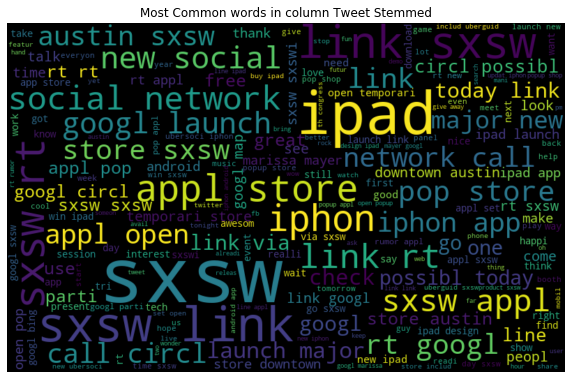

In [50]:
#visualizing all the words in column "tweet_stemmed" in our data using the wordcloud plot.
all_words = ' '.join([text for text in df_combine['tweet_stemmed']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet Stemmed")
plt.show()

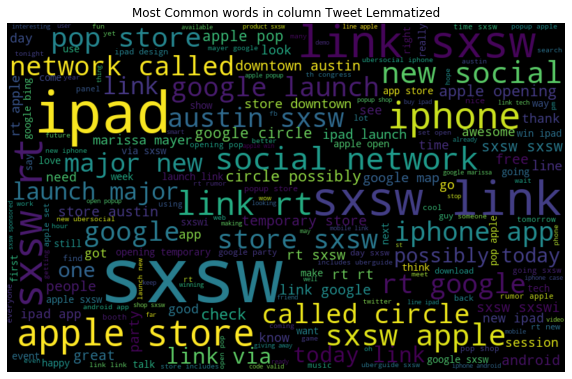

In [51]:
#Visualizing all the words in column "tweet_lemmatized" in our data using the wordcloud plot.
all_words = ' '.join([text for text in df_combine['tweet_lemmatized']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet Lemmatized")
plt.show()

### B) Most common words in negative

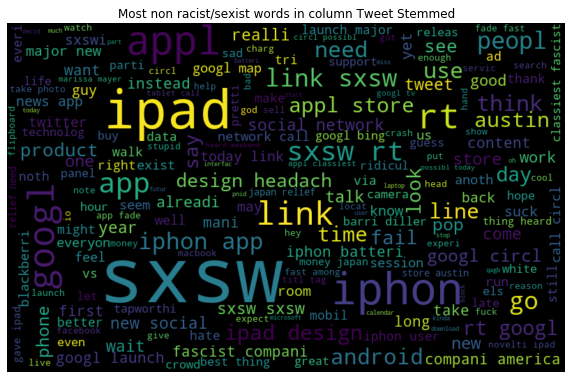

In [54]:
#Visualizing all the normal or non racist/sexist words in column "tweet_stemmed" in our data using the wordcloud plot.
neg_words =' '.join([text for text in df_combine['tweet_stemmed'][df_combine['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most non racist/sexist words in column Tweet Stemmed")
plt.show()

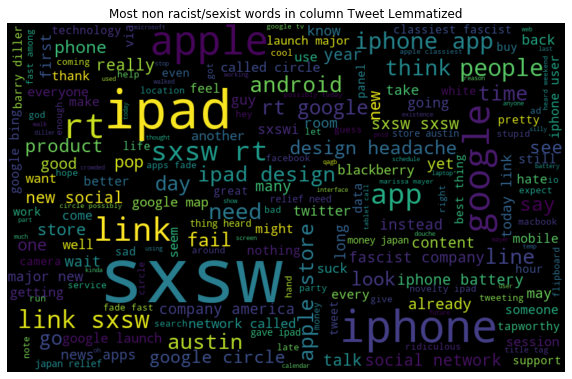

In [55]:
#Visualizing all the normal or non racist/sexist words in column "tweet_lemmatized" in our data using the wordcloud plot.
neg_words =' '.join([text for text in df_combine['tweet_lemmatized'][df_combine['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most non racist/sexist words in column Tweet Lemmatized")
plt.show()

## In above plots we can see most of the words are negative. With fail and headache being the most frequent ones.

### C) Most common words in positive

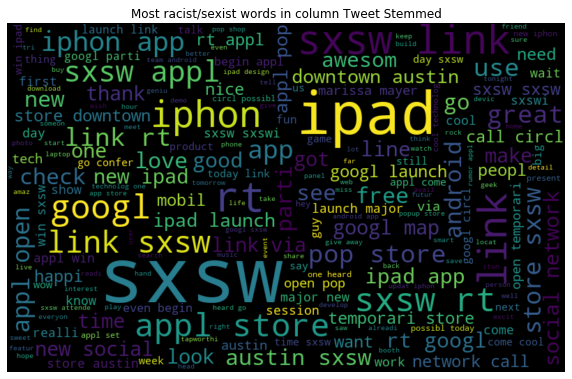

In [57]:
#Visualizing all the negative or racist/sexist words in column "tweet_stemmed" in our data using the wordcloud plot.
pos_words =' '.join([text for text in df_combine['tweet_stemmed'][df_combine['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most racist/sexist words in column Tweet Stemmed")
plt.show()

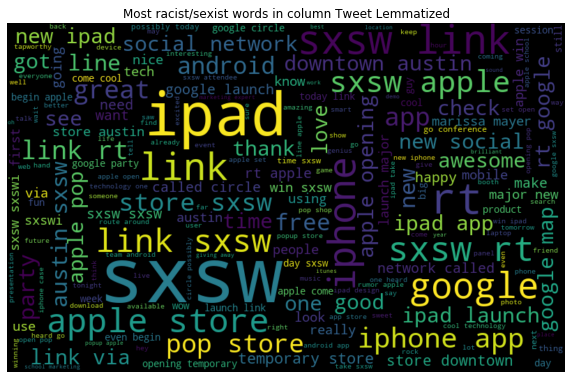

In [58]:
#Visualizing all the negative or racist/sexist words in column "tweet_lemmatized" in our data using the wordcloud plot.
pos_words =' '.join([text for text in df_combine['tweet_lemmatized'][df_combine['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most racist/sexist words in column Tweet Lemmatized")
plt.show()

## In above plots we can see most of the words are positive. Love and free being the most frequent ones.

# Extracting Features from Cleaned Tweets

## A - Bag-of-Words Features

In [34]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

## A.1 Bag-Of-Words feature matrix - For columns "combine_df['tweet_stemmed']"

In [40]:
# bag-of-words feature matrix - For columns "combine_df['tweet_stemmed']"
bow_stem = bow_vectorizer.fit_transform(df_combine['tweet_stemmed'])

## A.2 Bag-Of-Words feature matrix - For column - combine_df['tweet_lemmatized']

In [41]:
# bag-of-words feature matrix - For column - combine_df['tweet_lemmatized']
bow_lemm = bow_vectorizer.fit_transform(df_combine['tweet_lemmatized'])

## B - TF-IDF Features

In [37]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

## B.1 TF-IDF feature matrix - For columns "combine_df['tweet_stemmed']"

In [42]:
# TF-IDF feature matrix - For columns "combine_df['tweet_stemmed']"
tfidf_stem = tfidf_vectorizer.fit_transform(df_combine['tweet_stemmed'])

## B.2 TF-IDF feature matrix - For columns "combine_df['tweet_lemmatized']"

In [43]:
# TF-IDF feature matrix - For columns "combine_df['tweet_lemmatized']"
tfidf_lemm = tfidf_vectorizer.fit_transform(df_combine['tweet_lemmatized'])

# Logistic Regression Model Building: Twitter Sentiment Analysis

## A Building model using Bag-of-Words features

## A.1 For ['tweet_stemmed']

In [45]:
train_bow = bow_stem[:7274,:]
test_bow = bow_stem[7274:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_train['sentiment'], random_state=0, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

# prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
# prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 bthan 1 else 0
# prediction_int = prediction_int.astype(np.int)
prediction = lreg.predict(xvalid_bow)

A1 = f1_score(yvalid, prediction, average='weighted') # calculating f1 score
print(A1)

0.6397424262532124


c:\users\pankaj.pa.kumar\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
df_test['sentiment']= lreg.predict(test_bow)

In [47]:
filename = 'data/submission1.csv'      ## Got 0.65 in first submission
pd.DataFrame({'tweet_id': df_test.tweet_id, 'sentiment': df_test.sentiment}).to_csv(filename, index=False)

## A.2 For ['tweet_lemmatized']

In [48]:
train_bow = bow_lemm[:7274,:]
test_bow = bow_lemm[7274:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_train['sentiment'], random_state=0, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

# prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
# prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
# prediction_int = prediction_int.astype(np.int)
prediction = lreg.predict(xvalid_bow)

A2 = f1_score(yvalid, prediction, average='weighted')
print(A2)

0.6245827834128203


c:\users\pankaj.pa.kumar\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
df_test['sentiment']= lreg.predict(test_bow)

In [50]:
filename = 'data/submission2.csv'      ## Got 0.63 in 2nd submission
pd.DataFrame({'tweet_id': df_test.tweet_id, 'sentiment': df_test.sentiment}).to_csv(filename, index=False)

## B Building model using TF-IDF features

## B.1 For ['tweet_stemmed']

In [51]:
train_tfidf = tfidf_stem[:7274,:]
test_tfidf = tfidf_stem[7274:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

# prediction = lreg.predict_proba(xvalid_tfidf)
# prediction_int = prediction[:,1] >= 0.3
# prediction_int = prediction_int.astype(np.int)

prediction = lreg.predict(xvalid_tfidf)

B1 = f1_score(yvalid, prediction, average='weighted')
print(B1)

0.6229632986170369


In [52]:
df_test['sentiment']= lreg.predict(test_tfidf)

In [53]:
filename = 'data/submission3.csv'      ## Got 0.63 on 3rd submission
pd.DataFrame({'tweet_id': df_test.tweet_id, 'sentiment': df_test.sentiment}).to_csv(filename, index=False)

## B.2 For ['tweet_lemmatized']

In [54]:
train_tfidf = tfidf_lemm[:7274,:]
test_tfidf = tfidf_lemm[7274:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

# prediction = lreg.predict_proba(xvalid_tfidf)
# prediction_int = prediction[:,1] >= 0.3
# prediction_int = prediction_int.astype(np.int)
prediction = lreg.predict(xvalid_tfidf)

B2 = f1_score(yvalid, prediction, average='weighted')
print(B2)

0.6161388724787953


In [55]:
df_test['sentiment']= lreg.predict(test_tfidf)

In [56]:
filename = 'data/submission4.csv'      ## Got 0.61 on 4th submission
pd.DataFrame({'tweet_id': df_test.tweet_id, 'sentiment': df_test.sentiment}).to_csv(filename, index=False)

In [57]:
print("F1 - Score Chart")
print("* F1-Score - Model using Bag-of-Words features")
print("   F1-Score = ",A1," - For column tweets are stemmed")
print("   F1-Score = ",A2," - For column tweets are Lemmatized")
print("* F1-Score - Model using TF-IDF features")
print("   F1-Score = ",B1," - For column tweets are stemmed")
print("   F1-Score = ",B2," - For column tweets are Lemmatized")


F1 - Score Chart
* F1-Score - Model using Bag-of-Words features
   F1-Score =  0.6397424262532124  - For column tweets are stemmed
   F1-Score =  0.6245827834128203  - For column tweets are Lemmatized
* F1-Score - Model using TF-IDF features
   F1-Score =  0.6229632986170369  - For column tweets are stemmed
   F1-Score =  0.6161388724787953  - For column tweets are Lemmatized
